### Nested Clustered Optimization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from FinancialMachineLearning.generator.pca_blocks import formBlockMatrix, formTrueMatrix

corr0 = formBlockMatrix(nBlocks = 2, bSize = 2, bCorr = 0.5)

In [3]:
eVal, eVec = np.linalg.eigh(corr0)

In [4]:
print(max(eVal) / min(eVal))

3.0


<Axes: >

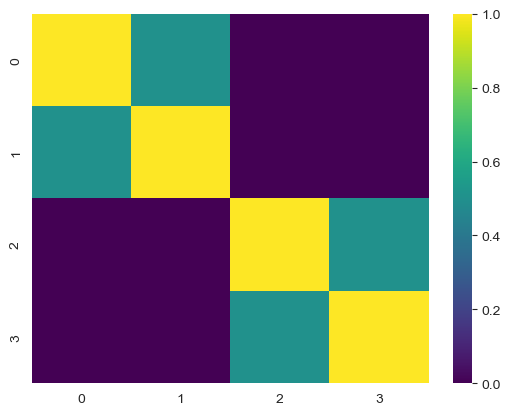

In [5]:
sns.heatmap(corr0, cmap = 'viridis')

지배적 블록을 가진 블록 - 대각 상관관계 행렬

In [6]:
from scipy.linalg import block_diag

corr0 = block_diag(formBlockMatrix(1, 2, 0.5))
corr1 = formBlockMatrix(1, 2, 0)
corr0 = block_diag(corr0, corr1)
eVal, eVec = np.linalg.eigh(corr0)

print(max(eVal) / min(eVal))

3.0


<Axes: >

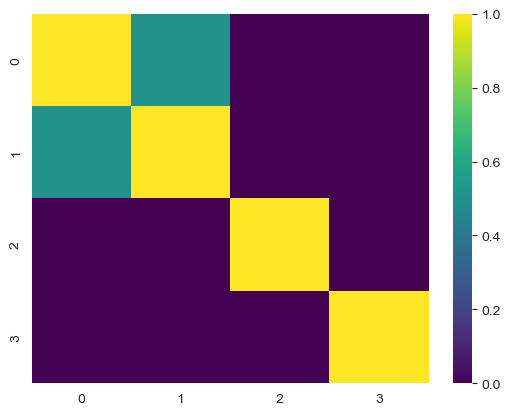

In [7]:
sns.heatmap(corr0, cmap = 'viridis')

#### Nested Clustered Optimization

마코위츠의 저주의 근원을 다룬 새로운 머신러닝 기법으로, wrapper라고 알려진 알고리즘의 종류에 속한다. 어떤 효율적 경계의 구성 원소가 계산되는지 여부나 어떤 제약 조건들이 부과되는지 여부에 대해서 무관하다. NCO는 마코위츠의 저주가 기존의 평균-분산 배분 방법에 미치는 영향을 해결하기 위한 전략을 제공한다.

**1. correlation clustering**

NCO의 첫 번째 단계는 상관 행렬을 군집화하는 것이다. 이 작업에는 최적의 군집 수를 찾는 작업이 포함된다. 

In [9]:
from FinancialMachineLearning.utils.stats import *
from FinancialMachineLearning.machine_learning.clustering import getPCA, denoise_constant_residual_eigenvalue, denoise_target_shrinkage, clusterKMeansBase, clusterKMeansTop

def deNoiseCov(cov0, q, bWidth):
    corr0 = covariance_to_correlation(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax0, var0 = find_max_eval(np.diag(eVal0), q, bWidth)
    nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1 = denoise_constant_residual_eigenvalue(eVal0, eVec0, nFacts0)  # denoising by constant residual eigenvalue method
    cov1 = correlation_to_covariance(corr1, np.diag(cov0) ** .5)
    return cov1

In [11]:
nBlocks, bSize, bCorr, q  = 2, 2, .5, 10
np.random.seed(42)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)

columns = cov0.columns
cov1 = deNoiseCov(cov0, q, bWidth = 0.01)
cov1 = pd.DataFrame(cov1, index = columns, columns = columns)
corr1 = covariance_to_correlation(cov1)
corr1, clusters1, silh = clusterKMeansBase(
    corr1, 
    maxNumClusters = int(corr0.shape[0] / 2),
    n_init = 10
)

**2. 군집 내 비중**

In [13]:
wIntra = pd.DataFrame(0, index = cov1.index, columns = clusters1.keys())
for i in clusters1 :
    wIntra.loc[clusters1[i], i] = optimizing_portfolio(cov1.loc[clusters1[i], clusters1[i]]).flatten()
cov2 = wIntra.T.dot(np.dot(cov1, wIntra))

In [15]:
wIntra

,0,1
1,-0.024845,0.000000
3,0.000000,0.017511
0,1.024845,0.000000
2,0.000000,0.982489


In [14]:
cov2

,0,1
0,0.005376,0.000000
1,0.000000,0.005383


**3. 군집 간 비중**

In [20]:
winter = pd.Series(optimizing_portfolio(cov2).flatten(), index = cov2.index)

In [21]:
winter

0    0.500317
1    0.499683
dtype: float64

In [22]:
wAII0 = wIntra.mul(winter, axis = 1).sum(axis = 1).sort_index()

In [23]:
wAII0

0    0.512747
1   -0.012430
2    0.490933
3    0.008750
dtype: float64

### Montecarlo Simulation

In [101]:
def nested_clustered_optimization(cov, mu = None, maxNumClusters = None) :
    cov = pd.DataFrame(cov)
    
    if mu is not None : mu = pd.Series(mu[:, 0])
    
    corr1 = covariance_to_correlation(cov)
    corr1, clusters, _ = clusterKMeansBase(corr1, maxNumClusters, n_init = 10)
    wIntra = pd.DataFrame(0, index = cov.index, columns = clusters.keys())
    
    for i in clusters :
        cov_ = cov.loc[clusters[i], clusters[i]].values
        if mu is None : mu_ = None
        else : mu_ = mu.loc[clusters[i]].values.reshape(-1, 1)
        wIntra.loc[clusters[i], i] = optimizing_portfolio(cov_, mu_).flatten()
        
    cov_ = wIntra.T.dot(np.dot(cov, wIntra))
    mu_ = (None if mu is None else wIntra.T.dot(mu))
    
    wInter = pd.Series(optimizing_portfolio(cov_, mu_).flatten(), index = cov_.index)
    nco = wIntra.mul(wInter, axis = 1).sum(axis = 1).values.reshape(-1, 1)
    
    return nco

In [102]:
nBlocks = 10
block_size = 50
block_corr = 0.5
np.random.seed(42)

mu0, cov0 = formTrueMatrix(nBlocks, block_size, block_corr)

In [106]:
num_observation = 1000
num_sims = 1000
shrink = False
minVarPortf = True
np.random.seed(42)

w1 = pd.DataFrame()
w1_d = pd.DataFrame()

In [107]:
from sklearn.covariance import LedoitWolf

def empirical_covariance_matrix(mu0, cov0, nObs, shrink = False): 
    x = np.random.multivariate_normal(mu0.flatten(),cov0,size = nObs) 
    mu1 = x.mean(axis = 0).reshape(-1,1)
    if shrink: cov1 = LedoitWolf().fit(x).covariance_ 
    else: cov1 = np.cov(x, rowvar = 0)
    return mu1, cov1

In [108]:
from tqdm import tqdm

for i in tqdm(range(num_sims)) :
    mu1, cov1 = empirical_covariance_matrix(mu0, cov0, num_observation, shrink = shrink)
    if minVarPortf : mu1 = None
    w1['weight'+str(i)] = optimizing_portfolio(cov1, mu1).flatten()
    w1_d['weight'+str(i)] = nested_clustered_optimization(
        cov1, mu1, int(cov1.shape[0] / 2)
    ).flatten()

  0%|          | 1/1000 [29:37<493:17:08, 1777.61s/it]


KeyboardInterrupt: 

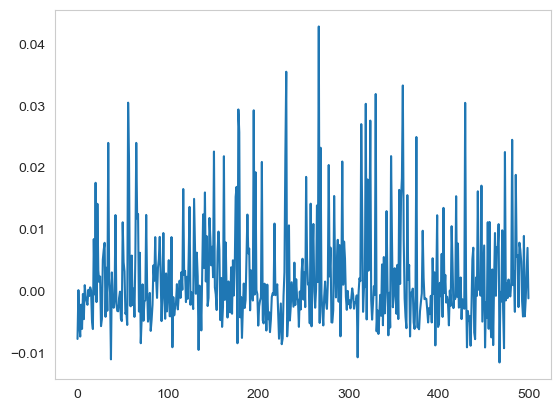

In [40]:
plt.plot(w1[0])
plt.grid(False)
plt.show()

In [44]:
mu1, cov1 = empirical_covariance_matrix(mu0, cov0, num_observation, shrink = shrink)

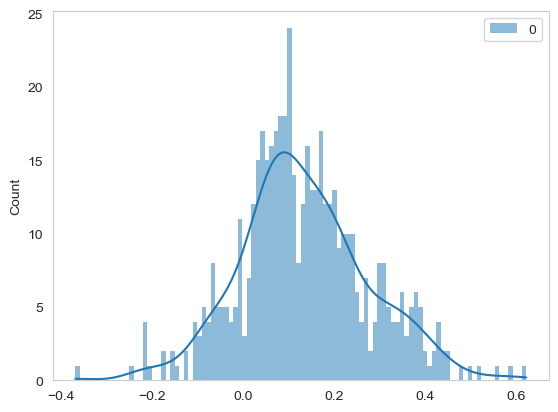

In [53]:
sns.histplot(mu1, bins = 100, edgecolor = 'none', kde = True)
plt.grid(False)
plt.show()